This is the dataset currently loaded:

1. [Sparcs Dataset ~2GB](https://www.usgs.gov/core-science-systems/nli/landsat/spatial-procedures-automated-removal-cloud-and-shadow-sparcs)
  1. satellite tiff file (format w/ multiple channels, i.e. infrared as well as RGB)
  2. txt metadata about the image
  3. a satellite image png
  4. a satellite mask png (with colors representing masks)

These are some other options we have:

1. [Landsat Validation Data ~100GB](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-8-cloud-cover-assessment-validation-data?qt-science_support_page_related_con=1#qt-science_support_page_related_con)

2. [Kaggle Dataset ~20GB](https://www.kaggle.com/sorour/95cloud-cloud-segmentation-on-satellite-images)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '15_GVb8BRHpDYKMwBmPlF7KaklBBJIKO-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('clouds.zip')

!unzip -q clouds.zip -d /content/
dataset_path = '/content/gdrive/MyDrive/sequoia/clouds'

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, layers, preprocessing 

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# convenience key-word args to parallel process
parallel_map_kwargs = dict(
  num_parallel_calls=tf.data.AUTOTUNE,
  deterministic=False)

In [ ]:
# #### DOWNLOAD THE SPARCS DATASET ####
# def download(data_url):
#   dl_manager = tfds.download.DownloadManager(download_dir='junk', extract_dir='/content/clouds')
#   dataset_path = dl_manager.download_and_extract(data_url)
#   return dataset_path

# # creates a dataset consisting of image file paths
# SPARCS_DATA_URL = 'https://landsat.usgs.gov/cloud-validation/sparcs/l8cloudmasks.zip'
# dataset_path = download(SPARCS_DATA_URL) + "/sending"

In [ ]:
#### READ IMAGE & MASK TO DATASET ####
def read_img_and_mask(img_path: tf.Tensor):
    # read img at specified path
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img)

    # read corresponding mask (whose path replaces 'photo' w/ 'mask')
    mask_path = tf.strings.regex_replace(img_path, "photo", "mask")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    # tuple of img and mask
    return img, mask

In [ ]:
ds = tf.data.Dataset.list_files(dataset_path + '/*photo.png')
# read in each image and its mask using those file paths 

ds = ds.map(read_img_and_mask, **parallel_map_kwargs)

# size of dataset
CARDINALITY = ds.cardinality()

In [ ]:
# take n random crops of an image and its mask
@tf.function
def sample_crop(img, mask, w, h, n):
  img_and_mask = tf.experimental.numpy.dstack((img, mask))
  crops = [tf.image.random_crop(img_and_mask, (w, h, 4)) for i in range(n)]
  crops = tf.stack(crops)
  crops = tf.data.Dataset.from_tensor_slices(crops)
  return crops

In [ ]:
# randomly crop each img (and its mask) several times
n, w, h = 5, 128, 128
ds = ds.interleave(lambda img, mask: sample_crop(img, mask, w, h, n), **parallel_map_kwargs)

# tf doesn't know cardinality after interleave, so we help it out
CARDINALITY *= n
ds = ds.apply(tf.data.experimental.assert_cardinality(CARDINALITY))

In [ ]:
# represent as tuple of img, mask rather than mask stacked beneath image
ds = ds.map(lambda x: (x[:, :, 0:3], x[:, :, 3]), **parallel_map_kwargs)

In [ ]:
@tf.function
def cloud_score(img, mask):  
  # cloud mask is 5
  clouds = tf.math.count_nonzero(mask == 255)
  cloud_score = clouds / tf.size(mask, out_type=tf.int64)
  return img, cloud_score

ds = ds.map(cloud_score, **parallel_map_kwargs)

In [ ]:
# random shuffle
ds = ds.shuffle(buffer_size=CARDINALITY)

train_ds_size = int(3 * CARDINALITY // 5) # 60
valid_ds_size = int(CARDINALITY // 5) # 20

train_ds = ds.take(train_ds_size)
remaining = ds.skip(train_ds_size)  
valid_ds = remaining.take(valid_ds_size)
test_ds = remaining.skip(valid_ds_size)

train_ds = train_ds.batch(256).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(256).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(256).prefetch(tf.data.AUTOTUNE)

In [ ]:
num_classes = 1

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(h, w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=5
)

In [ ]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=15,
  callbacks=[callback]
)

Epoch 1/15
1/1 [==============================] - 7s 7s/step - loss: 0.1438 - val_loss: 0.0758
Epoch 2/15
1/1 [==============================] - 6s 6s/step - loss: 0.0932 - val_loss: 0.0579
Epoch 3/15
1/1 [==============================] - 6s 6s/step - loss: 0.0911 - val_loss: 0.0729
Epoch 4/15
1/1 [==============================] - 6s 6s/step - loss: 0.0796 - val_loss: 0.0734
Epoch 5/15
1/1 [==============================] - 6s 6s/step - loss: 0.0834 - val_loss: 0.0571
Epoch 6/15
1/1 [==============================] - 6s 6s/step - loss: 0.0661 - val_loss: 0.0833
Epoch 7/15
1/1 [==============================] - 6s 6s/step - loss: 0.0733 - val_loss: 0.0683
Epoch 8/15
1/1 [==============================] - 6s 6s/step - loss: 0.0748 - val_loss: 0.1056


In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.0561


0.056101810187101364

In [ ]:
actuals, diffs = [], []

for img, score in test_ds:
  actual = score.numpy()
  pred = model.predict(img).squeeze()
  diff = actual - pred
  
  actuals.append(actual)
  diffs.append(diff)


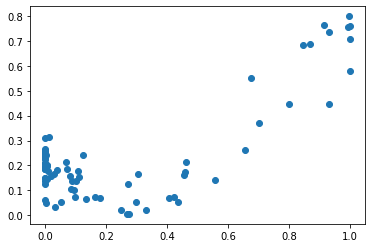

In [ ]:
actuals = np.concatenate(actuals)
diffs = np.concatenate(diffs)

plt.scatter(actuals, np.abs(diffs))